# DSCI 100 Final Project

# Introduction

PLAICraft is a project initiated by the research group Pacific Laboratory for Artificial Intelligence (PLAI)from the University of British Columbia's Department of Computer Science(PLAICraft, 2024). The goal of the project is to create an AI model that acts and responds like a human in the virtual world of Minecraft (PLAICraft, 2024). 

The purpose of our project is to investigate if age and experience levels are an accurate predictor of total playing hours. If the predictors are accurate, PLAI can then create a player profile based on age and experience level to recruit players that generate the most data. 

Data containing the players' information and their session time was collected in two Minecraft datasets. Since the sessions dataset did not provide any useful information regarding the players' characteristics, we only used the players dataset in our model. The players dataset contains informations on 196 different players with observations made from following variables:

  
|Variable name  |Variable type|     Meaning          | 
|:--------------|:-----------|:----------------------|
|Experience     |factor      |Contains 5 elements: Beginner, Amateur, Regular, Pro, and Veteran; indicates the experience level of the player in Minecraft from least to most experienced|
|subscribe      |logical     |Either TRUE, meaning the player has subscribed by email, or not, represented by FALSE|
|hashedEmail    |character   |The email that the player used to sign up, coded for anonymity| 
|played_hours   |double      |The total hours that each players has played, ranging from 0-223.1 hours|
|name           |character   |The name of each player|
|gender         |factor      |The players' gender identity being either female, male, non-binary, two-spirit, prefer not to say, other, or agender| 
|age            |integer     |The age of the player ranging from 8-99 years old|    
|individual ID  | character         |Used to identify each player in the game|
|organizationName| character       |The name of the organization that each player belongs to|

We picked the variables age and experience as our two predictors to predict playing hours. Both age and experience are closely associated with the player's knowledge and familiarity with Minecraft, and therefore will influence the length of their playing hours. A third predictor was not chosen to ensure that our regression model will run smoothly and effectively. Thus, our research question is: Does the age and experience level of a player accurately predict the total number of played hours on Minecraft using KNN regression? 

# Methods & Results

A regression algorithm was chosen to perform a predictive analysis on the target variable, playing hours, because it is a numerical variable.The K-NN regression algorithm was chosen because it is compatible with data with either a linear or non-linear relationship. Contrastingly, the linear regression algorithm only works well with data that has a linear relationship. Therefore, the K-NN regression algorithm was chosen to ensure that the model will be compatible with future data collected. Furthermore, the K-NN regression algorithm requires minimal assumptions concerning data distribution and relationships and can be used to perform multivariable regression. Using the K-NN regression algorithm, the age and experience level associated with the largest length of playing hours can be determined and assist PLAI's recruitment process. 

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
set.seed(100)

url_players <- "https://drive.google.com/uc?export=download&id=1Mw9vW0hjTJwRWx0bDXiSpYsO3gKogaPz"

players <- read_csv(url_players)


Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
set.seed(100)

players_select <- players|> 
          select(experience, age, played_hours)

In [4]:
players_numerical <- players_select|>                    
                     mutate(experience_num = case_when(experience == "Veteran" ~ 5,
                                                       experience == "Pro" ~ 4,
                                                       experience == "Regular" ~ 3,
                                                       experience == "Amateur" ~ 2,
                                                       experience == "Beginner" ~ 1))|>
                    select(-experience)

The data was loaded into R and wrangled where only the variables of interest were selected being played hours, experience, and age. The experience variable is of a character data type and was mutated to have a numerical value because the K-NN regression algorithm requires all predictors to be numerical. Each experience level was assigned a number from 1 to 5, corresponding to an ordered data type. For example, an experience level of 1 corresponded to the lowest level (Beginner), while the experience level of 5 corresponded to the highest level (Veteran). 

In [5]:
set.seed(100)

players_split <- initial_split(players_numerical, prop = 0.75, strata = played_hours)
players_training <- training(players_split)
players_testing <- testing(players_split)

The wrangled dataset was split  into a training set containing 75% of the complete dataset, and a testing set containing 25% of the complete dataset. The data was split up to ensure that the model will only be trained on the training data set, and the effectiveness of the model can be evaluated on the testing data set. If the model was exposed to the testing data when it is being trained, the model would appear to be better at predicting the response variable because the model was exposed to the data previously. Splitting the data ensures that the model will be accurately evaluated.

Warning message in geom_histogram(stat = "identity"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”


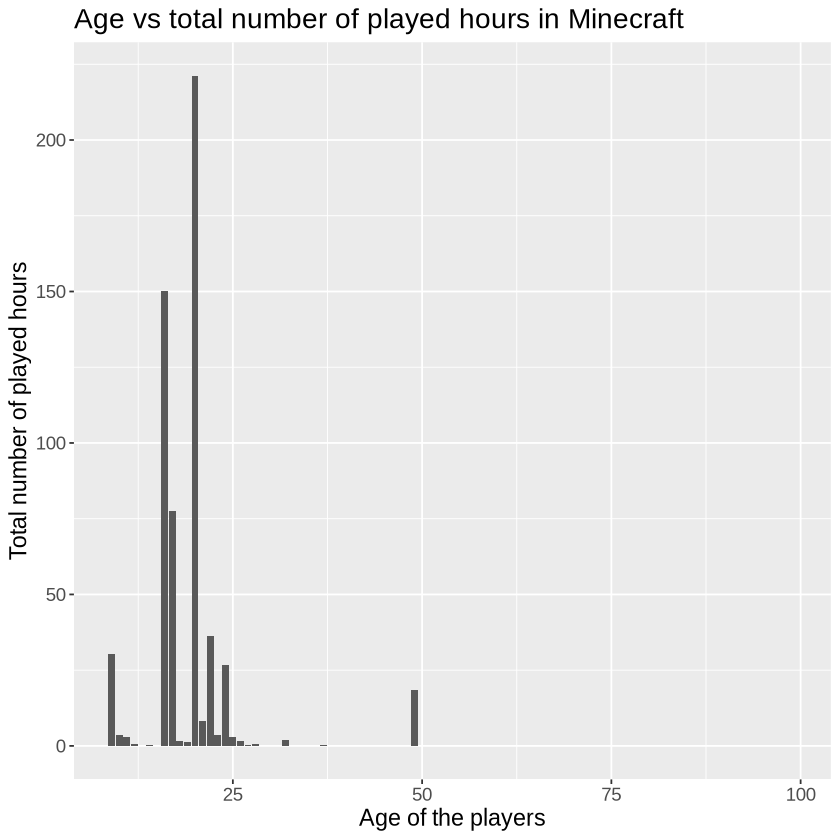

In [24]:
set.seed(100)

age_training_plot <- players_training|> 
                     ggplot(aes(x=age, 
                                y=played_hours))+
                     geom_histogram(stat = "identity")+
                     labs(x = "Age of the players",
                          y = "Total number of played hours")+
                     ggtitle("Age vs total number of played hours in Minecraft")+
                     theme(text = element_text(size=14))
age_training_plot 

Figure 1: An exploratory histogram plot displaying the relationship between the total played hours and the age of each player from the training dataset. The histogram is right-skewed, where older players had a larger number of total played hours.

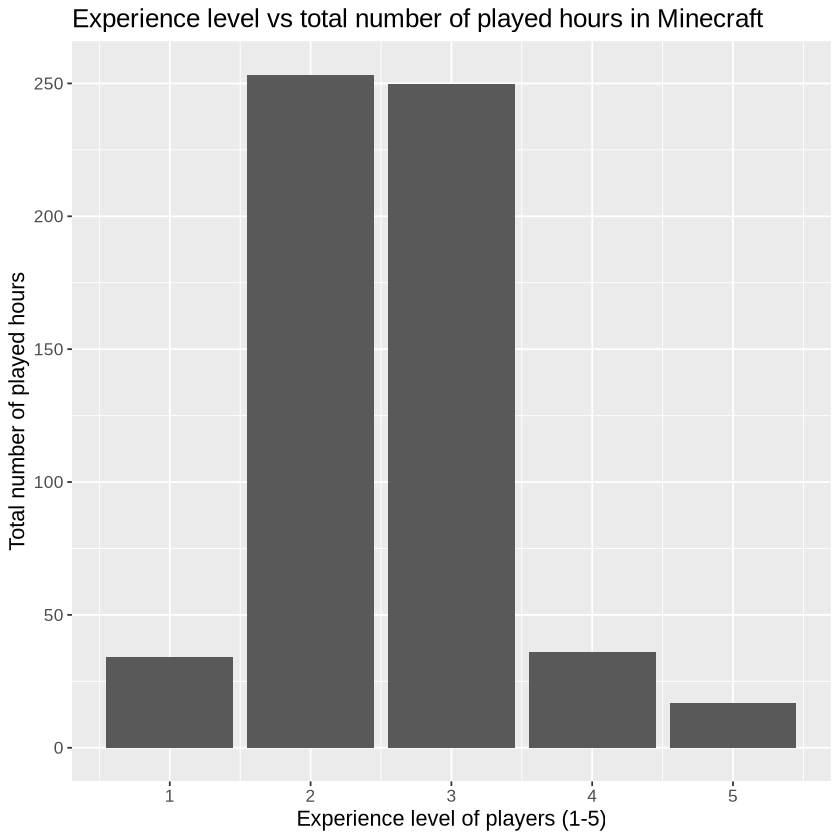

In [23]:
set.seed(100)


experience_training_plot <- players_training|> 
                            ggplot(aes(x=experience_num, 
                                       y=played_hours))+
                            geom_bar(stat = "identity")+
                            labs(x = "Experience level of players (1-5)",
                                 y = "Total number of played hours")+
                            ggtitle("Experience level vs total number of played hours in Minecraft")+
                            theme(text = element_text(size=13))
experience_training_plot 

Figure 2: An exploratory bar chart showing the relationship between the total number of hours played and the players’ experience level from the training dataset. Players with an experience level of 3 (Regular) have the highest total number of played hours, followed by an experience level of 2 (Amateur). The initial distribution of data suggests that players with a Regular and Amateur experience level contributes the most data.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


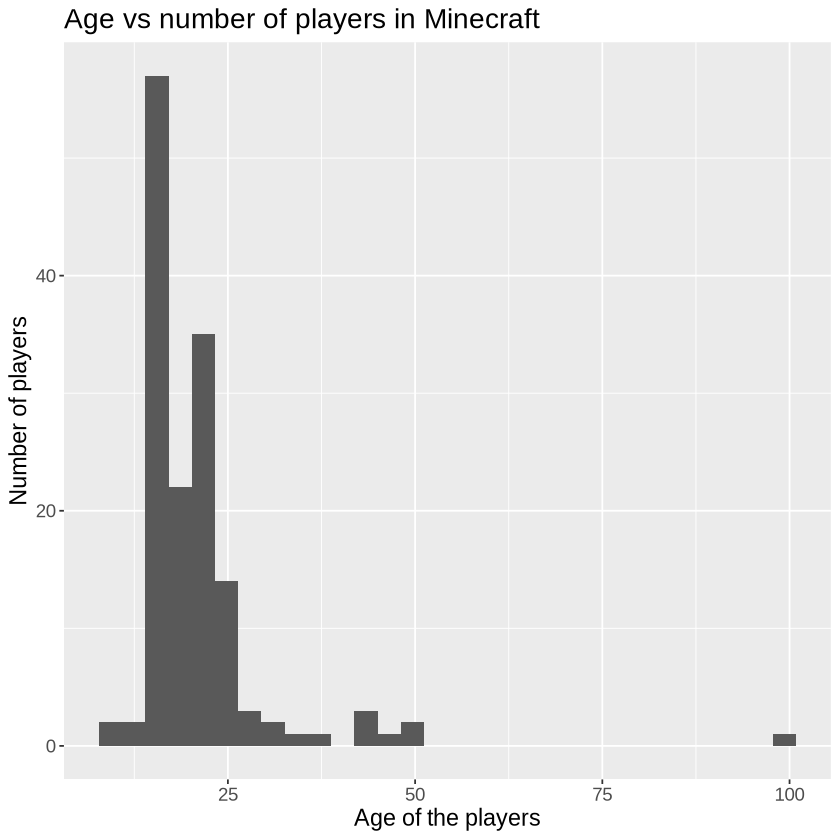

In [8]:
set.seed(100)

outlier_age_training_plot <- players_training|> 
                             ggplot(aes(x=age))+
                             geom_histogram()+
                             labs(x = "Age of the players",
                                  y = "Number of players")+
                             ggtitle("Age vs number of players in Minecraft")+
                             theme(text = element_text(size=14))
outlier_age_training_plot 

Figure 3: An exploratory histogram showing the relationship between age and total number of players. Players that are older than 80 years old are distributed far away from the rest of the data and appear to be outliers. 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


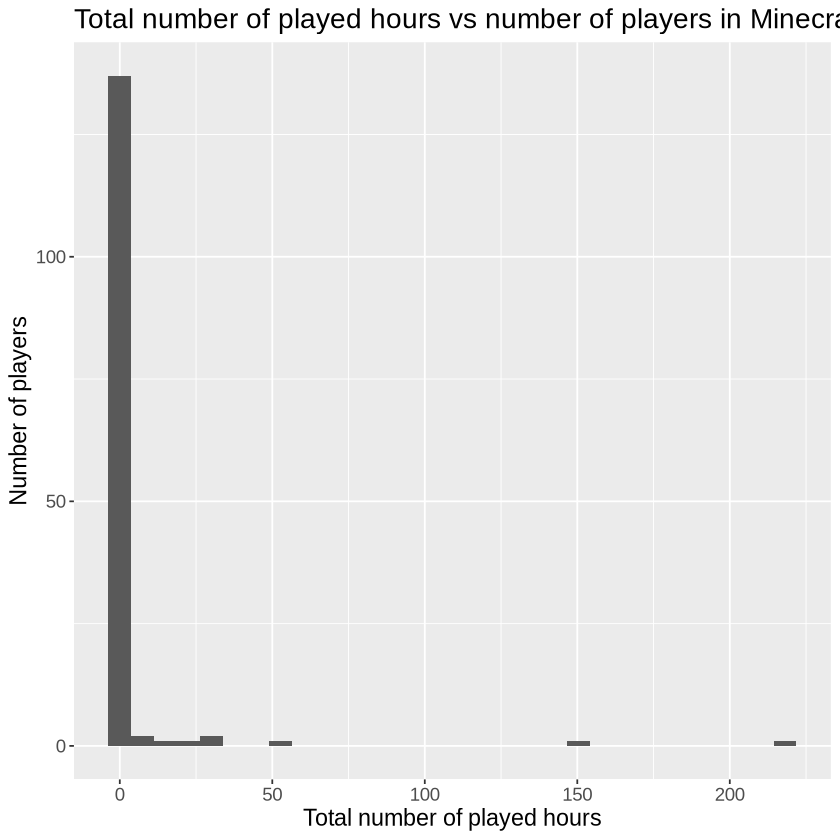

In [25]:
set.seed(100)

age_training_plot <- players_training|> 
                     ggplot(aes(x=played_hours))+
                     geom_histogram()+
                     labs(x = "Total number of played hours",
                          y = "Number of players")+
                     ggtitle("Total number of played hours vs number of players in Minecraft")+
                     theme(text = element_text(size=14))
age_training_plot 

Figure 4: An exploratory histogram showing the relationship between total number of hours played and total number of players. Players that played for more than 125 hours are distributed far away from the rest of the data and appear to be outliers. 

In [10]:
set.seed(100)

players_recipe <- recipe(played_hours ~ experience_num + age, data = players_training) |>
                   step_scale(all_predictors()) |>
                   step_center(all_predictors())

players_spec <- nearest_neighbor(weight_func = "rectangular", 
                                 neighbors = tune()) |> 
                set_engine("kknn") |>
                set_mode("regression") 

A recipe and model for the K-NN regression algorithm was created using the complete training data set. The predictors, age and experience level, were scaled to ensure that both variables have an equal effect on the prediction of the response variable.

In [11]:
set.seed(100)

players_vfold <- vfold_cv(data =players_training, v = 10, strata = played_hours)

players_workflow <- workflow() |>
                     add_recipe(players_recipe) |>
                     add_model(players_spec)


To chose the number of K neighbours that provides the best prediction, 
A 10-fold cross-validation object was created from the training data, to choose the number of K neighbours that provides the best prediction. Cross-validation allows a better K neighbours value to be chosen as the accuracy of the K neighbours chosen from one split can be tested on the 9 other splits of the training data set. 

A workflow was then created using the "players_recipe" and "players_spec". 

In [12]:
set.seed(100)

set.seed(1)
gridvals <- tibble(neighbors = seq(from = 1, to = 85, by = 5))

players_results_min <- players_workflow |>
                       tune_grid(resamples = players_vfold, grid = gridvals)|> 
                       collect_metrics()|> 
                       filter(.metric == "rmse")|>
                       filter(mean == min(mean))
head(players_results_min)

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
36,rmse,standard,15.30063,10,5.746113,Preprocessor1_Model08


Cross-validation was performed on a grid ranging from 1 to 85 to test which value for K neighbours is associated with the lowest RMPSE value. The number of K-nearest neighbours will be selected based on the lowest RMPSE value. The RMPSE measures the accuracy of the model by finding the sum of the squared difference between the predicted value of the response variable as compared to the observed value. A lower RMPSE value corresponds to a smaller difference between the predicted and observed values and therefore a better prediction. For this model, the lowest RMPSE value of 15.30063 hours was obtained when K = 36. 

In [13]:
set.seed(100)

k_min <- players_results_min |>
         pull(neighbors)

players_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) |>
                     set_engine("kknn") |>
                     set_mode("regression")

players_fit <- workflow() |>
               add_recipe(players_recipe) |>
               add_model(players_best_spec) |>
               fit(data = players_training)


players_summary <- players_fit |>
                   predict(players_testing) |>
                   bind_cols(players_testing) |>
                   metrics(truth = played_hours, estimate = .pred)|>
                   filter(.metric == "rmse")
players_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,40.40059


The performance of the model was analyzed using the testing data using 36 neighbours. A very large RMSE value of 40.40059 hours was obtained suggesting that the K-NN regression model cannot accurately predict the total number of played hours based on age and experience level.

# Creating K-NN regression model without suspected outliers

In [14]:
set.seed(100)

players_training_clean <- players_training|> 
                          filter(played_hours < 125,
                                 age < 80)

Based on the exploratory plots above, the training data was wrangled to remove the suspected outliers. Players that played more than 100 total hours and are older than 80 were removed from the filtered data set.

Warning message in geom_histogram(stat = "identity"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”


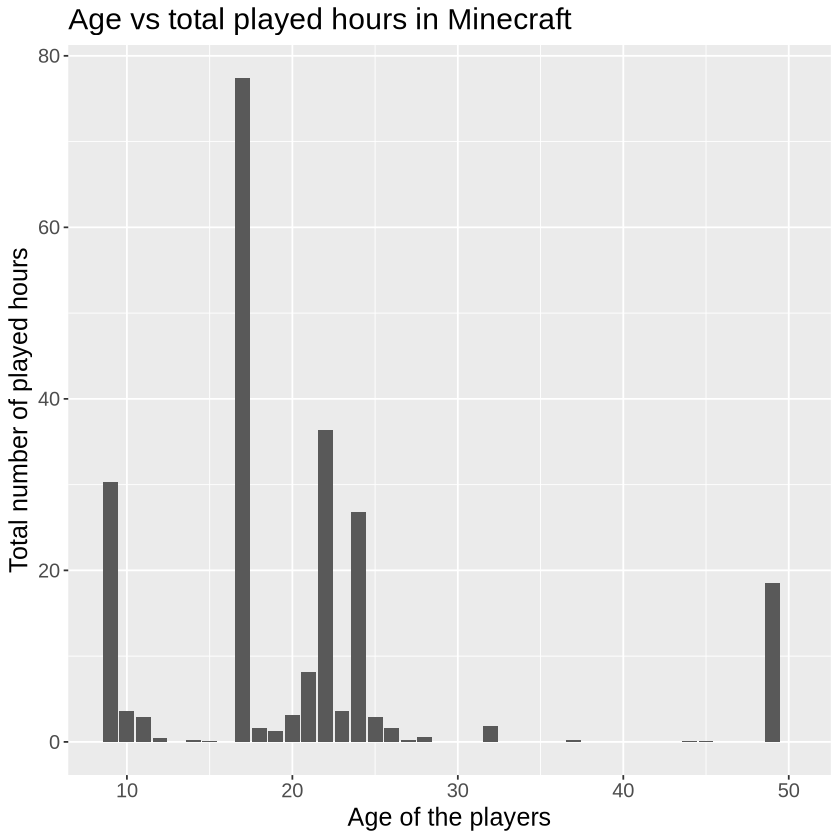

In [26]:
set.seed(100)
age_training_plot <- players_training_clean|> 
                     ggplot(aes(x=age, 
                                y=played_hours))+
                     geom_histogram(stat = "identity")+
                     labs(x = "Age of the players",
                          y = "Total number of played hours")+
                     ggtitle("Age vs total played hours in Minecraft")+
                     theme(text = element_text(size=15))
age_training_plot 

Figure 5: A histogram showing the relationship between the age of each player and the total played hours in Minecraft using training data without the suspected outliers. Once again, the largest total number of hours of play are concentrated in the 15 to 30 age group even after the exclusion of the outliers.

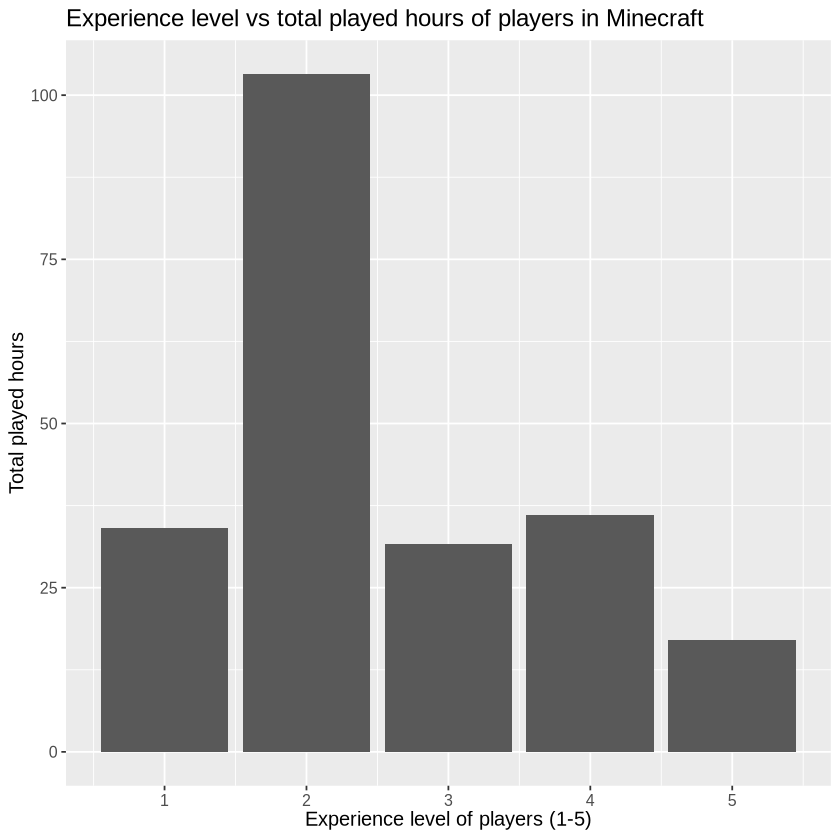

In [16]:
# removed outliers when play time was above 150
set.seed(100)

experience_training_plot <- players_training_clean|> 
                            ggplot(aes(x=experience_num, 
                                       y=played_hours))+
                            geom_bar(stat = "identity")+
                            labs(x = "Experience level of players (1-5)",
                                 y = "Total played hours")+
                            ggtitle("Experience level vs total played hours of players in Minecraft")+
                            theme(text = element_text(size=12))
experience_training_plot 

Figure 6: A bar chart displaying the relationship between the total number of played hours and their experience levels without the suspected outliers. Players with experience level of 2 (Amateur) have the largest number of total played hours, suggesting that they contribute the most data. However, in figure 2, players with an experience level of 3 (Regular) had the largest number of total played hours, followed by an experience level of 2 (Amateur) demonstrating that excluding outliers has an effect on the model.

In [17]:
# receipe for the knn regression without outliers
set.seed(100)

players_recipe_clean <- recipe(played_hours ~ experience_num + age, data = players_training_clean) |>
                        step_scale(all_predictors()) |>
                        step_center(all_predictors())

players_spec_clean <- nearest_neighbor(weight_func = "rectangular", 
                                 neighbors = tune()) |> 
                set_engine("kknn") |>
                set_mode("regression") 

A recipe and model for the K-NN regression algorithm was created using the training data set excluding suspected outliers. Once again, the predictors, age and experience level, were scaled. 

In [18]:
# cross - validation using 5 folds without outliers
set.seed(100)

players_vfold <- vfold_cv(data =players_training_clean, v = 10, strata = played_hours)

players_workflow_clean <- workflow() |>
                          add_recipe(players_recipe_clean) |>
                          add_model(players_spec_clean)


gridvals <- tibble(neighbors = seq(from = 1, to = 85, by = 5))

players_results_min_clean <- players_workflow_clean |>
                             tune_grid(resamples = players_vfold, grid = gridvals)|> 
                             collect_metrics()|> 
                             filter(.metric == "rmse")|>
                             filter(mean == min(mean))
head(players_results_min_clean)


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
81,rmse,standard,4.570846,10,1.477436,Preprocessor1_Model17


The same steps are followed as described above using training data excluding the outliers rather than the complete training data. The lowest RMPSE value of 4.570846 hours was obtained when K = 81. It was found that the RMPSE value decreased significantly from 15.30063 hours to 4.310367 hours when the training data excluded the suspected outliers. A smaller RMPSE value is correlated with a model that has more accurate predictions. Therefore, it can be concluded that data points where the age was above 80, and the number of total played hours is above 125 are outliers, and the model will perform better when the outliers are excluded. 

In [19]:
set.seed(100)

k_min_clean <- players_results_min_clean |>
               pull(neighbors)

players_best_spec_clean <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) |>
                     set_engine("kknn") |>
                     set_mode("regression")

players_fit <- workflow() |>
               add_recipe(players_recipe_clean) |>
               add_model(players_best_spec_clean) |>
               fit(data = players_training_clean)


players_summary <- players_fit |>
                   predict(players_testing) |>
                   bind_cols(players_testing) |>
                   metrics(truth = played_hours, estimate = .pred)|>
                   filter(.metric == "rmse")
players_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,41.38549


The performance of the model was investigated on the testing data set using 81 neighbours. An even larger RMSE value of 41.46298 hours was obtained suggesting that the K-NN regression model cannot accurately predict the total number of played hours based on age and experience level even when outliers are removed.

Warning message:
“tune samples were requested but there were 143 rows in the data. 138 will be used.”
Warning message in geom_histogram(stat = "identity"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”


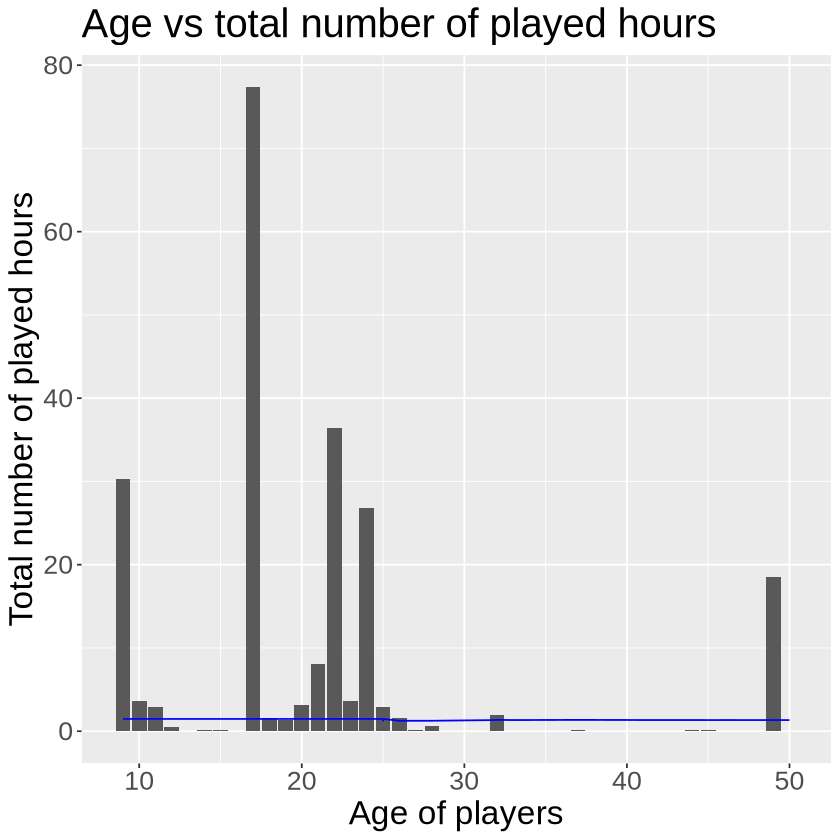

In [20]:
players_workflow_clean2 <- workflow() |>
                          add_recipe(players_recipe_clean) |>
                          add_model(players_spec_clean)|>
                          fit(data = players_training_clean)

player_preds <-  players_workflow_clean2 |>
              predict(players_training_clean) |>
              bind_cols(players_training_clean)


age_analysis_plot <- ggplot(player_preds, aes(x = age, y = played_hours)) +
                     geom_histogram(stat = "identity") +
                     xlab("Age of players") +
                     ylab("Total number of played hours") + 
                     geom_line(data = player_preds, aes(x = age, y = .pred), color = "blue") +
                     ggtitle("Age vs total number of played hours") +
                     theme(text = element_text(size = 20))

age_analysis_plot

Figure 7. A bar chart showing the relationship between the observed total number of played hours and the age of the players. The blue line represents the predicted values of the played time based on age using the final K-NN regression model. 

The predicted values appears to be constant and does not follow the observed data suggesting that the model is underfitting; the value of K neighbors chosen may be too large and caused the model to not be sensitive enough to the trends of the data. Along with the large RMSE values, it indicates that K-NN regression cannot accurately predict the total number of played hours using age as a predictor.

Warning message in geom_histogram(stat = "identity"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”


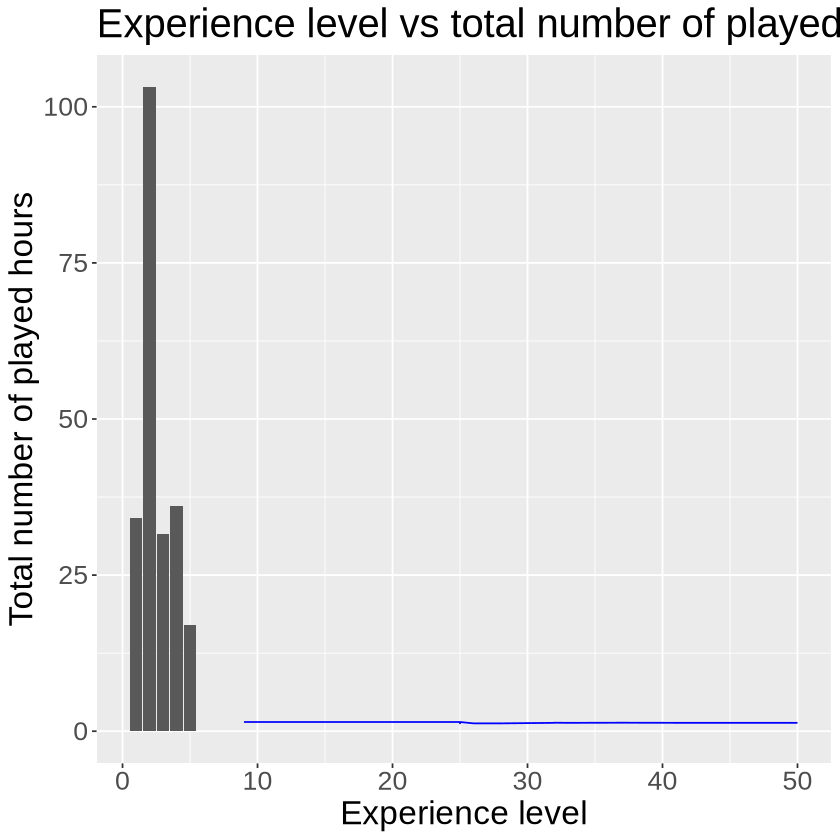

In [27]:
age_analysis_plot <- ggplot(player_preds, aes(x = experience_num, y = played_hours)) +
                     geom_histogram(stat = "identity") +
                     xlab("Experience level") +
                     ylab("Total number of played hours") + 
                     geom_line(data = player_preds, aes(x = age, y = .pred), color = "blue") +
                     ggtitle("Experience level vs total number of played hours") +
                     theme(text = element_text(size = 20))

age_analysis_plot

Figure 8. A bar chart indicating the relationship between the observed values of total number of played hours and player’s experience level. The blue line represents the predicted values of the played time based on experience level using the final K-NN regression model. 

Similarly, this visualization has a large difference between the observed and predicted value of total number of play time, which aligns with the large RMSE value obtained.  Once again, the K-NN regression model underfits the data suggesting that the value of K neighbors chosen may be too large. The model did not accurately predict the total number of played hours using experience level as a predictor.

# Discussion 

### Summary of results

- The predictors age and experience level cannot accurately predict the total number of play time using the K-NN regression algorithm as indicated by the large RMSE value (41.38549 hours). Observing figure 7 and 8, the model unfits the data and visually demonstrates that the model does not accurately predict the response variable. Using a smaller value of K neighbours may lead to more accurate predictors as the model will be more sensitive to the trends of the data. 
- The K-NN regression model using the complete training data and the K-NN regression model  using the training data without outliers had a very large RMSE value of 40.40059 hours and 41.38549 hours respectively. A  larger RMSE value was obtained when the outliers were excluded.
- To improve the model, other predictors such as gender can be used in the model to generate a better player profile as other predictors may be a better predictor for the response variable.

### Discuss whether this is what you expected to find?

No, this is not what we expected to find. We expected age and experience level to be good predictors for the response variable, the total number of played hours because we expected these variables to have a large impact on how long a player would be interested in playing Minecraft. 

Additionally, we expected the model to perform better on the testing data when the outliers were removed rather than more poorly as seen in the increase in RMSE value. Since the dataset has a low number of data points, removing some data points led to a significant decrease in the amount of data which potentially factored into the unexpected result. Collecting more data may lead to a better performing model. 


### Discuss what future questions could this lead to?

- Does the gender of a player accurately predict the total number of played hours in Minecraft using KNN regression?
- Does the age and experience level of a player accurately predict the time interval that most players play Minecraft using KNN regression?
-  Does the age and experience level of a player accurately predict the length of individual sessions in Minecraft using KNN regression?

References

PLAICraft. (2024). Plaicraft.ai. https://plaicraft.ai/